# Dynamic ecoregions

## Define inputs

In [1]:
# Inputs
input_file = "data/data-continental-united-states.csv"
geocode_precision = 4
log_file = "run.log"
output_file = "output.geojson"
num_clusters = 30

## Set up logging

In [2]:
import logging

logging.basicConfig(filename=log_file, encoding="utf-8", level=logging.INFO)

## Data flow

In [3]:
from src.mermaid import build_mermaid_graph

build_mermaid_graph()

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## `DarwinCoreCsvLazyFrame`

### Build

In [4]:
from src.lazyframes.darwin_core_csv import DarwinCoreCsvLazyFrame

darwin_core_csv_lazy_frame = DarwinCoreCsvLazyFrame.build(input_file)

### Preview

In [5]:
darwin_core_csv_lazy_frame.lf.limit(3).collect()

gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,infraspecificEpithet,taxonRank,scientificName,verbatimScientificName,verbatimScientificNameAuthorship,countryCode,locality,stateProvince,occurrenceStatus,individualCount,publishingOrgKey,decimalLatitude,decimalLongitude,coordinateUncertaintyInMeters,coordinatePrecision,elevation,elevationAccuracy,depth,depthAccuracy,eventDate,day,month,year,taxonKey,speciesKey,basisOfRecord,institutionCode,collectionCode,catalogNumber,recordNumber,identifiedBy,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue
str,str,str,enum,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,u64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""4424226317""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Libellulidae""","""Sympetrum""",null,null,"""GENUS""","""Sympetrum Newman, 1833""","""Sympetrum""",null,"""US""",null,"""New York""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",42.96266,-76.740947,"""2191.0""",null,null,null,null,null,"""2019-09-06T10:30""","""6""","""9""","""2019""",1428195,null,"""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32505913""",null,"""Amy Guala""","""2019-09-11T01:33:07""","""CC_BY_NC_4_0""","""Amy Guala""","""Amy Guala""",null,null,"""2024-12-03T00:52:33.467Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423028148""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Lepidoptera""","""Geometridae""","""Nematocampa""","""Nematocampa resistaria""",null,"""SPECIES""","""Nematocampa resistaria (Herric…","""Nematocampa resistaria""",null,"""US""",null,"""Vermont""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",43.822608,-72.641412,"""5.0""",null,null,null,null,null,"""2019-09-11T22:08:52""","""11""","""9""","""2019""",1991012,"""1991012""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32566956""",null,"""bugguytad""","""2019-09-12T02:25:38""","""CC_BY_NC_4_0""","""bugguytad""","""bugguytad""",null,null,"""2024-12-03T01:38:46.617Z""","""StillImage;StillImage;StillIma…","""COORDINATE_ROUNDED;CONTINENT_D…"
"""2423041120""","""50c9509d-22c7-4a22-a47d-8c4842…","""https://www.inaturalist.org/ob…","""Animalia""","""Arthropoda""","""Insecta""","""Odonata""","""Coenagrionidae""","""Argia""","""Argia moesta""",null,"""SPECIES""","""Argia moesta (Hagen, 1861)""","""Argia moesta""",null,"""US""",null,"""Texas""","""PRESENT""",null,"""28eb1a3f-1c15-4a95-931a-4af90e…",30.99463,-103.662658,null,null,null,null,null,null,"""2019-09-08T09:01""","""8""","""9""","""2019""",5051399,"""5051399""","""HUMAN_OBSERVATION""","""iNaturalist""","""Observations""","""32612673""",null,"""Todd Fitzgerald""","""2019-09-12T22:11:30""","""CC_BY_NC_4_0""","""Todd Fitzgerald""","""Todd Fitzgerald""",null,null,"""2024-12-03T01:38:10.816Z""","""StillImage""","""COORDINATE_ROUNDED;CONTINENT_D…"


## `GeohashDataFrame`

### Build

In [6]:
from src.dataframes.geocode import GeocodeDataFrame

geocode_dataframe = GeocodeDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
)

### Shape

In [7]:
geocode_dataframe.df.shape

(7416, 4)

### Preview

In [8]:
geocode_dataframe.df.limit(6)

geocode,center,direct_neighbors,direct_and_indirect_neighbors
str,struct[2],list[str],list[str]
"""840e491ffffffff""","{49.369298,-67.913007}","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]","[""840e497ffffffff"", ""840e493ffffffff"", ""840e49bffffffff""]"
"""840e493ffffffff""","{48.946311,-67.83016}","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]","[""840e49bffffffff"", ""840e491ffffffff"", … ""842b14dffffffff""]"
"""840e497ffffffff""","{49.104076,-68.442117}","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]","[""840e491ffffffff"", ""840e4bbffffffff"", … ""840e493ffffffff""]"
"""840e49bffffffff""","{49.208357,-67.299825}","[""842b325ffffffff"", ""840e491ffffffff"", … ""842b327ffffffff""]","[""842b325ffffffff"", ""840e491ffffffff"", … ""842b327ffffffff""]"
"""840e4b1ffffffff""","{49.410776,-69.681628}","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]","[""840e4b7ffffffff"", ""840e4b3ffffffff"", ""840e4bbffffffff""]"
"""840e4b3ffffffff""","{48.988427,-69.580742}","[""840e4bbffffffff"", ""840e4b1ffffffff"", … ""842b16dffffffff""]","[""840e4bbffffffff"", ""840e4b1ffffffff"", … ""842b16dffffffff""]"


## `TaxonomyDataFrame`

### Build

In [9]:
from src.dataframes.taxonomy import TaxonomyDataFrame

taxonomy_dataframe = TaxonomyDataFrame.build(darwin_core_csv_lazy_frame)

### Preview

In [10]:
taxonomy_dataframe.df.limit(3)

kingdom,phylum,class,order,family,genus,species,taxonRank,scientificName
enum,str,str,str,str,str,str,str,str
"""Plantae""","""Marchantiophyta""","""Jungermanniopsida""","""Jungermanniales""","""Gymnomitriaceae""","""Marsupella""","""Marsupella emarginata""","""SPECIES""","""Marsupella emarginata (Ehrh.) …"
"""Animalia""","""Arthropoda""","""Insecta""","""Diptera""","""Syrphidae""","""Spilomyia""","""Spilomyia foxleei""","""SPECIES""","""Spilomyia foxleei Vockeroth, 1…"
"""Plantae""","""Tracheophyta""","""Magnoliopsida""","""Gentianales""","""Rubiaceae""","""Crusea""","""Crusea wrightii""","""VARIETY""","""Crusea wrightii var. wrightii"""


## `GeohashSpeciesCountsDataFrame`

### Build

In [11]:
from src.dataframes.geocode_taxa_counts import GeocodeTaxaCountsDataFrame

geocode_taxa_counts_dataframe = GeocodeTaxaCountsDataFrame.build(
    darwin_core_csv_lazy_frame,
    geocode_precision,
)

### Shape

In [12]:
geocode_taxa_counts_dataframe.df.shape

(5416157, 5)

### Preview

In [13]:
geocode_taxa_counts_dataframe.df.limit(3)

geocode,kingdom,taxonRank,scientificName,count
str,enum,str,str,u32
"""840e491ffffffff""","""Animalia""","""SPECIES""","""Gavia pacifica (Lawrence, 1858…",1
"""840e491ffffffff""","""Plantae""","""SPECIES""","""Triglochin maritima L.""",1
"""840e491ffffffff""","""Animalia""","""SPECIES""","""Anas rubripes Brewster, 1902""",9


## `ConnectivityMatrix`

### Build

In [14]:
from src.matrices.connectivity import ConnectivityMatrix

connectivity_matrix = ConnectivityMatrix.build(geocode_dataframe)

### Preview

In [15]:
connectivity_matrix._connectivity_matrix

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 0, ..., 0, 1, 0]])

## `DistanceMatrix`

### Build

In [16]:
from src.matrices.distance import DistanceMatrix

distance_matrix = DistanceMatrix.build(
    geocode_taxa_counts_dataframe,
    geocode_dataframe,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Shape

In [17]:
distance_matrix.squareform().shape

(7416, 7416)

### Preview

In [18]:
distance_matrix.squareform()

array([[0.00000000e+00, 1.93216941e-05, 3.01455350e-05, ...,
        2.44196676e-03, 2.08110535e-03, 2.10442727e-03],
       [1.93216941e-05, 0.00000000e+00, 4.75506406e-05, ...,
        2.42863366e-03, 2.06830774e-03, 2.09140819e-03],
       [3.01455350e-05, 4.75506406e-05, 0.00000000e+00, ...,
        2.45324583e-03, 2.09344146e-03, 2.11722254e-03],
       ...,
       [2.44196676e-03, 2.42863366e-03, 2.45324583e-03, ...,
        0.00000000e+00, 1.35456866e-03, 1.39979897e-03],
       [2.08110535e-03, 2.06830774e-03, 2.09344146e-03, ...,
        1.35456866e-03, 0.00000000e+00, 6.13010193e-05],
       [2.10442727e-03, 2.09140819e-03, 2.11722254e-03, ...,
        1.39979897e-03, 6.13010193e-05, 0.00000000e+00]])

## `GeohashClusterDataFrame`

### Build

In [19]:
from src.dataframes.geocode_cluster import GeocodeClusterDataFrame

geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
    geocode_dataframe,
    distance_matrix,
    connectivity_matrix,
    # num_clusters,
    100,
)

### Preview

In [20]:
geocode_cluster_dataframe.df.limit(3)

geocode,cluster
str,u32
"""840e491ffffffff""",20
"""840e493ffffffff""",20
"""840e497ffffffff""",20


In [21]:
# # TMP

# from src.dataframes.geocode_cluster import GeocodeClusterDataFrame
# from sklearn.metrics import silhouette_score

# results = []

# for i in range(2, 200):
#     geocode_cluster_dataframe = GeocodeClusterDataFrame.build(
#         geocode_dataframe,
#         distance_matrix,
#         connectivity_matrix,
#         num_clusters=i,
#     )
#     score = silhouette_score(
#         X=distance_matrix.squareform(),
#         labels=geocode_cluster_dataframe.df["cluster"],
#         metric="precomputed",
#     )
#     print(f"{i}: {score}")
#     results.append((i, score))

# results


## `ClusterNeighborsDataframe`

### Build

In [22]:
from src.dataframes.cluster_neighbors import ClusterNeighborsDataFrame

cluster_neighbors_dataframe = ClusterNeighborsDataFrame.build(
    geocode_dataframe,
    geocode_cluster_dataframe,
)

### Preview

In [23]:
cluster_neighbors_dataframe.df.limit(5)

cluster,direct_neighbors,direct_and_indirect_neighbors
u32,list[u32],list[u32]
0,"[2, 70, … 23]","[2, 70, … 24]"
1,[35],[35]
2,"[0, 8, … 60]","[0, 8, … 60]"
3,"[36, 5, … 22]","[36, 5, … 22]"
4,"[98, 6, … 22]","[98, 6, … 22]"


## `ClusterColorDataFrame`

### Build

In [24]:
from src.dataframes.cluster_color import ClusterColorDataFrame

cluster_colors_dataframe = ClusterColorDataFrame.build(cluster_neighbors_dataframe)

### Preview

In [25]:
cluster_colors_dataframe.df.limit(3)

cluster,color
u32,str
20,"""#fcf500"""
7,"""#fcf500"""
43,"""#fcf500"""


## Silhouette score

In [26]:

from sklearn.metrics import silhouette_score

silhouette_score(
    X=distance_matrix.squareform(),
    labels=geocode_cluster_dataframe.df["cluster"],
    metric="precomputed",
)


np.float64(0.02484703612660983)

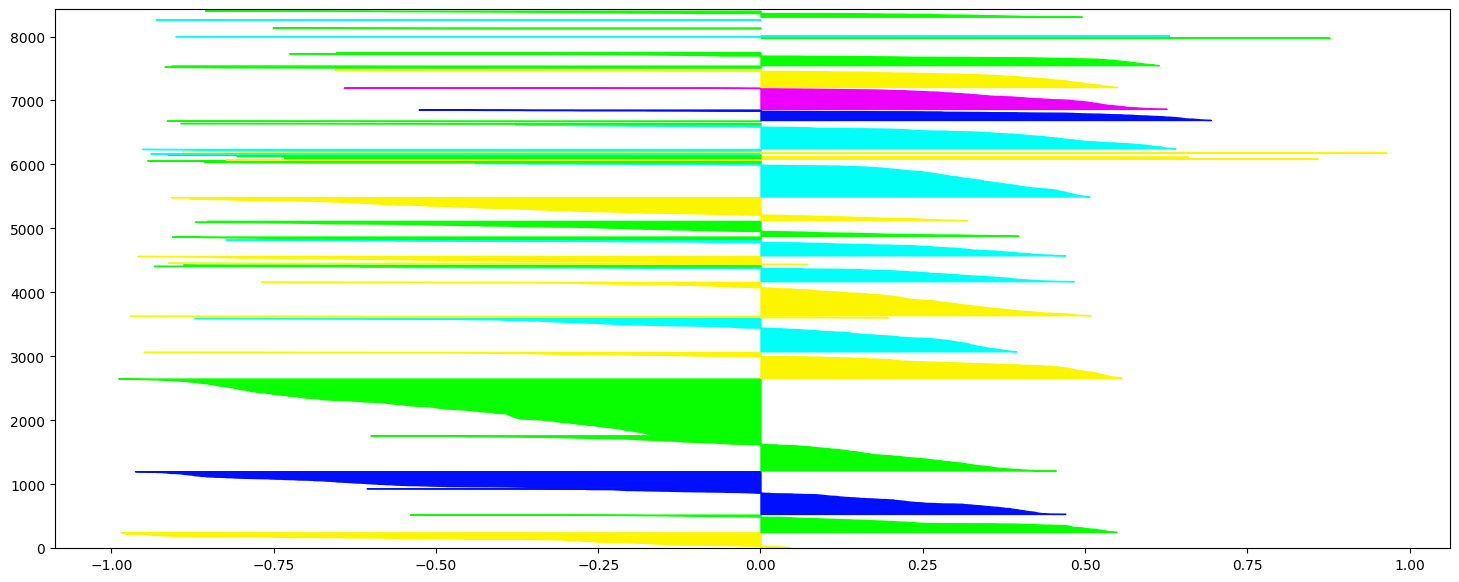

In [27]:
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import polars as pl
import matplotlib.pyplot as plt
import numpy as np

samples = silhouette_samples(
    X=distance_matrix.squareform(),
    labels=geocode_cluster_dataframe.df["cluster"],
    metric="precomputed",
)

new = geocode_cluster_dataframe.df.with_columns(
    pl.Series(
        name="sample",
        values=samples,
    )
)

n_clusters = len(geocode_cluster_dataframe.df["cluster"].unique())
n_geocodes = len(distance_matrix.squareform())

# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots()
fig.set_size_inches(18, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
# ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, n_geocodes + (n_clusters + 1) * 10])

y_lower = 10
for i, cluster in enumerate(geocode_cluster_dataframe.df["cluster"].unique()):
    ith_cluster_silhouette_values = (new.filter(pl.col("cluster") == cluster).sort("sample", descending=True))["sample"]

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color =  cluster_colors_dataframe.get_color_for_cluster(cluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
    )

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples


## `ClusterTaxaStatisticsDataFrame`

### Build

In [1]:
from src.dataframes.cluster_taxa_statistics import ClusterTaxaStatisticsDataFrame

cluster_taxa_statistics_dataframe = ClusterTaxaStatisticsDataFrame.build(
    geocode_taxa_counts_dataframe,
    geocode_cluster_dataframe,
    taxonomy_dataframe,
)

/Users/coreyf/dev/frewsxcv/citizen-science-ecoregions-experiments/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'geocode_taxa_counts_dataframe' is not defined

### Preview

In [29]:
cluster_taxa_statistics_dataframe.df.limit(3)

cluster,kingdom,taxonRank,scientificName,count,average
u32,enum,str,str,u32,f64
null,"""Animalia""","""SPECIES""","""Monochroa placidella (Zeller, …",5,9.7235e-8
null,"""Animalia""","""SPECIES""","""Alconeura unipuncta (Gillette,…",16,3.1115e-7
null,"""Animalia""","""SPECIES""","""Asphondylia foliosa Gagné, 199…",113,0.000002


## `ClusterSignificantDifferencesDataFrame`

### Build

In [30]:
from src.dataframes.cluster_significant_differences import ClusterSignificantDifferencesDataFrame

cluster_significant_differences_dataframe = ClusterSignificantDifferencesDataFrame.build(
    cluster_taxa_statistics_dataframe,
)

### Preview

In [31]:
cluster_significant_differences_dataframe.df.limit(3)

cluster,kingdom,taxonRank,scientificName,percentage_difference
u32,str,str,str,f64
0,"""Animalia""","""SPECIES""","""Phoebastria nigripes (Audubon,…",146892.130112
0,"""Animalia""","""SPECIES""","""Megaptera novaeangliae (Borows…",19235.48783
0,"""Animalia""","""SPECIES""","""Ardenna creatopus (Coues, 1864…",120192.848026


## Build and plot GeoJSON feature collection

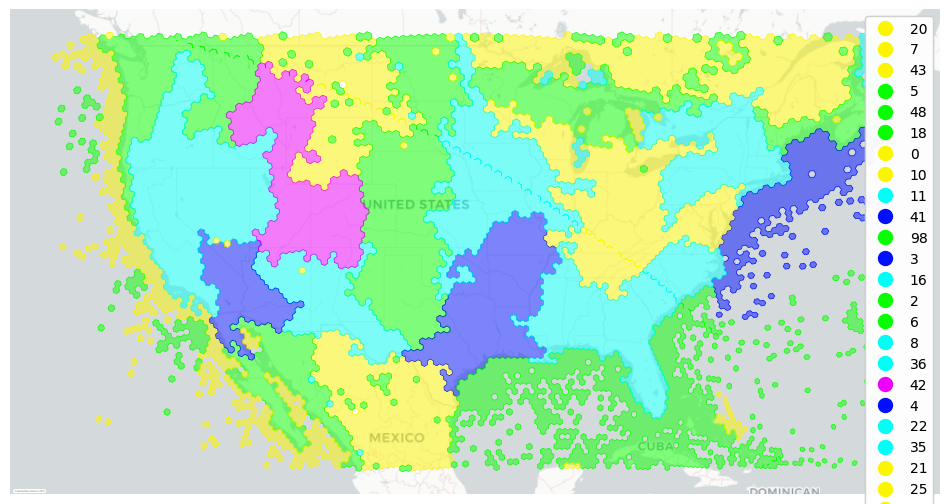

In [32]:
from src.geojson import build_geojson_feature_collection, write_geojson
from src.render import plot_clusters
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams['figure.figsize'] = [12, 7]

feature_collection = build_geojson_feature_collection(
    geocode_cluster_dataframe,
    cluster_colors_dataframe,
)

# print_results(darwin_core_aggregations, all_stats, cluster_dataframe)

write_geojson(feature_collection, output_file)

plot_clusters(feature_collection)

## Build and display HTML output

In [33]:
from src.html_output import build_html_output
from IPython.display import display, HTML

html = build_html_output(
    cluster_colors_dataframe,
    cluster_significant_differences_dataframe,
)

display(HTML(html))


## TSNE 2d plot

In [34]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=42,
    metric="precomputed",
    init="random",
    perplexity=min(30, distance_matrix.squareform().shape[0] - 1), # HACK FOR SMALLER DATASETS
)
X_tsne = tsne.fit_transform(distance_matrix.squareform())
tsne.kl_divergence_


0.5605227947235107

In [ ]:
import umap

umap = umap.UMAP(
    n_components=2,
    metric="precomputed",
    random_state=42,
    n_neighbors=3000,
    # min_dist=1,
    # init="random",
)
X_umap = umap.fit_transform(distance_matrix.squareform())


<Axes: >

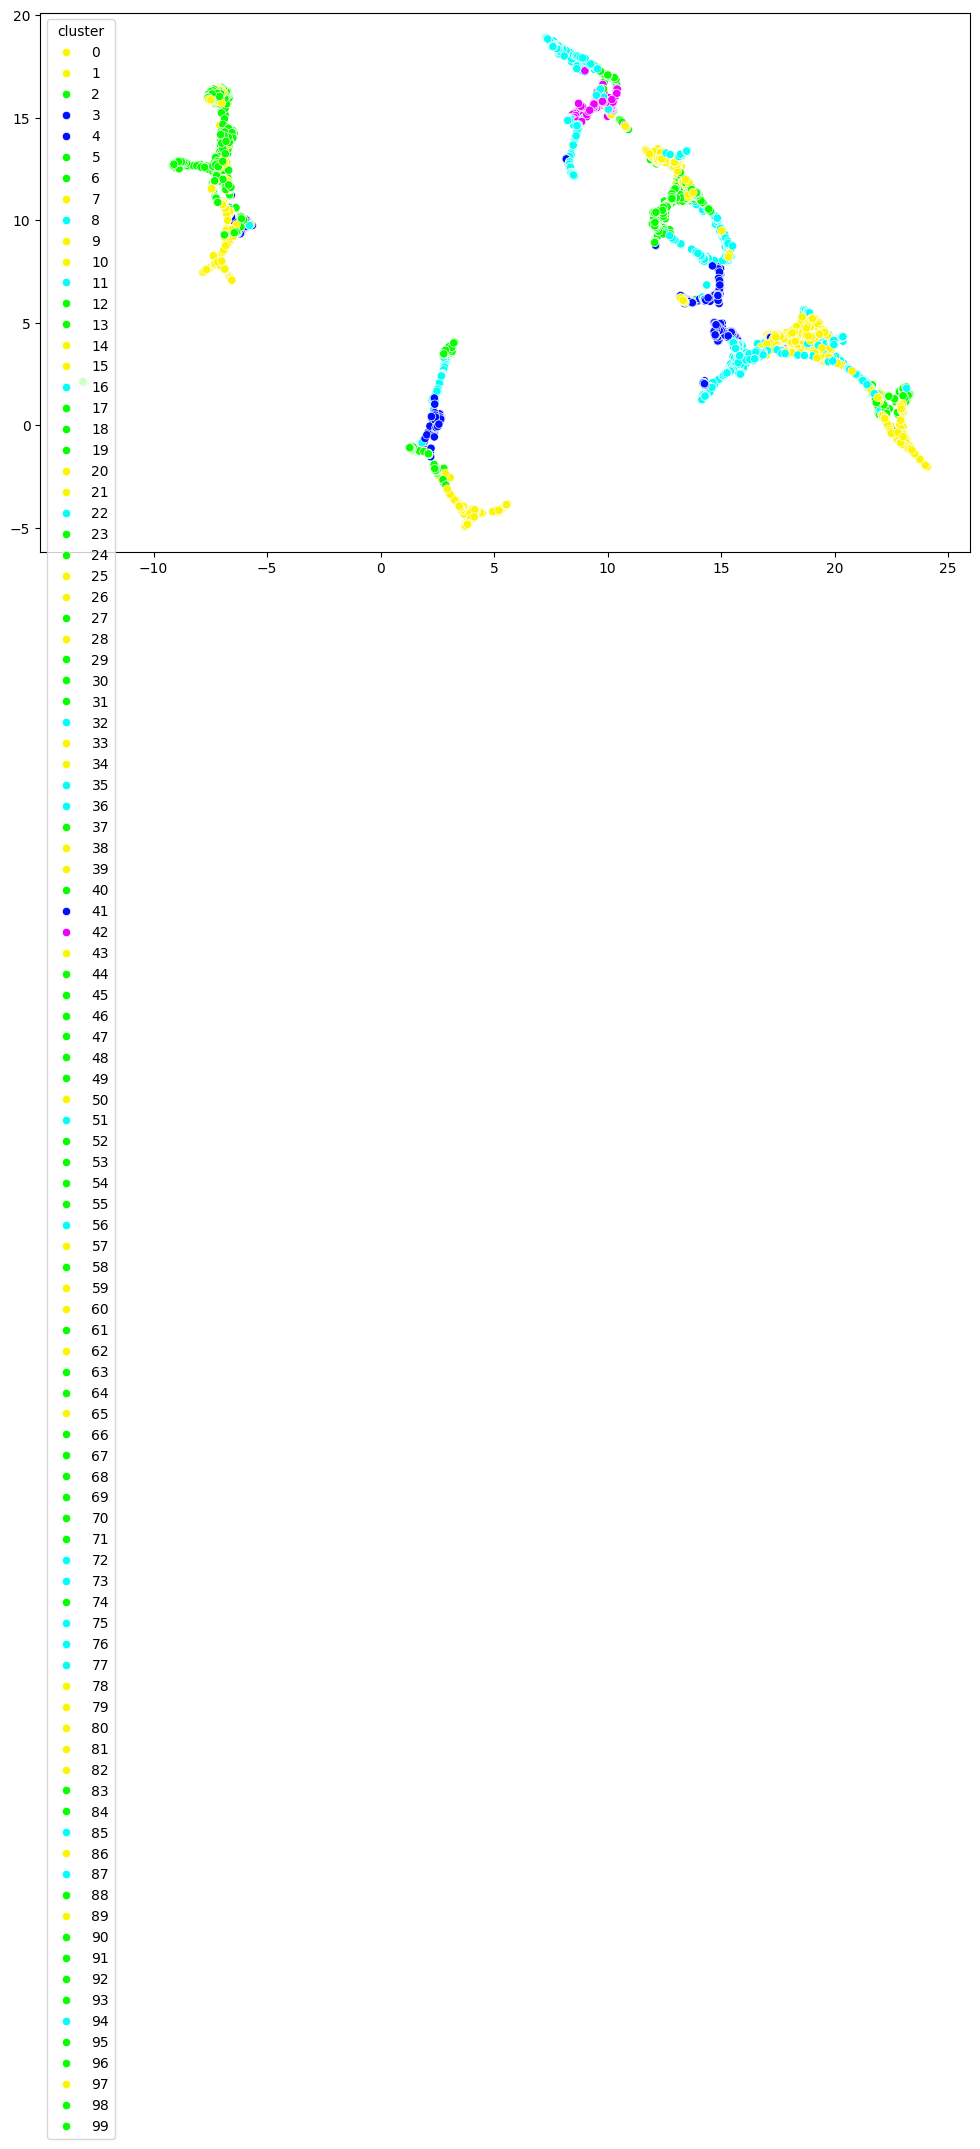

In [36]:
import seaborn as sns

sns.scatterplot(
    x=X_umap[:, 0],
    y=X_umap[:, 1],
    hue=geocode_cluster_dataframe.df["cluster"],
    palette=cluster_colors_dataframe.to_dict(),
    alpha=1,
)

## Clustermap visualization

In [37]:
import seaborn as sns
import polars as pl
from scipy.cluster.hierarchy import linkage


linkage_array = linkage(distance_matrix.condensed(), "ward")

ordered_geocodes = geocode_dataframe.df["geocode"].unique()

def min_max_normalize(series: pl.Series) -> pl.Series:
    return (series - series.min()) / (series.max() - series.min())

col_colors = []
for geocode in ordered_geocodes:
    cluster = geocode_cluster_dataframe.cluster_for_geocode(geocode)
    col_colors.append(cluster_colors_dataframe.get_color_for_cluster(cluster))

data = {}
for species, kingdom, taxonRank in cluster_significant_differences_dataframe.df.select("scientificName", "kingdom", "taxonRank").unique().iter_rows():
    counts = []

    for geocode in ordered_geocodes:
        geocode_counts_species = geocode_taxa_counts_dataframe.df.filter(
            pl.col("geocode") == geocode, pl.col("scientificName") == species
        ).get_column("count").sum()
        geocode_counts_all = geocode_taxa_counts_dataframe.df.filter(
            pl.col("geocode") == geocode
        ).get_column("count").sum()
        geocode_average = geocode_counts_species / geocode_counts_all
        all_average = (
            cluster_taxa_statistics_dataframe.df.filter(
                pl.col("kingdom") == kingdom,
                pl.col("scientificName") == species,
                pl.col("cluster").is_null(),
                pl.col("taxonRank") == taxonRank,
            )
            .get_column("average")
            .item()
        )
        counts.append(geocode_average - all_average)
    counts = pl.Series(
        values=counts,
        name=species,
    )
    # counts = counts / counts.max()
    # counts = counts.pow(1 / 3)
    data[species] = min_max_normalize(counts)


KeyboardInterrupt: 

In [ ]:
dataframe = pl.DataFrame(data=data)
sns.clustermap(
    data=dataframe,
    col_cluster=False,
    row_cluster=True,
    row_linkage=linkage_array,
    row_colors=col_colors,
    xticklabels=dataframe.columns,
    yticklabels=False,
)